<a href="https://colab.research.google.com/github/vincent-grari/FAGTB/blob/master/FAGTB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clone the Github Repository

In [ ]:
!pip3 install fairness
!git clone https://github.com/vincent-grari/FAGTB
import urllib.request, sys, os
!bash -c '/content/FAGTB/ProcessedData.py', '/usr/local/lib/python3.6/dist-packages/fairness/data/objects/ProcessedData.py'
sys.path.append('FAGTB')

Import all libraries and functions

In [ ]:
from functions import *

Import the Adult UCI data set

In [6]:
X_train, X_test, y_train, y_test, sensitive, sensitivet = DATA_TRAIN_TEST(1,'sex',"income-per-year",['sex','income-per-year','race-sex'])  #,'race','race-sex','sex'

Train an unfair GTB:

In [ ]:
table = [0,0,0,0]
for k  in range(10):
    np.random.seed()
    X_train, X_test, y_train, y_test, sensitive, sensitivet = DATA_TRAIN_TEST(1,'sex',"income-per-year",['sex','income-per-year','race-sex']) 
    
    gb = GradientBoostingClassifier(n_estimators=500, learning_rate = 0.05, max_depth = 3, max_features=90,random_state=0,  min_impurity_decrease=0.0, min_impurity_split=None,
      min_samples_leaf=2, min_samples_split=2,
      min_weight_fraction_leaf=0.0,
      presort='auto')
    gb.fit(X_train, y_train)

    ##### Results on Test dataset #####
    y_predt2= gb.predict_proba(X_test.values)[:,1]
    print('')
    print('Results on test set :')
    Res = display_results(y_predt2, y_test.values, sensitivet)
    table = np.vstack([table,[Res['Accuracy']*100,Res['PRULE'],Res['DispFPR'],Res['DispFNR']]])


Results for Funfair FAGTB

> The results correspond in the following order: Accuracy, PRULE, DispFPR, DispFNR)




In [41]:
np.set_printoptions(suppress=True) 
np.mean(table[1:,], axis=0).astype(float)

array([86.74656853, 31.88873801,  0.06260405,  0.07074619])

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


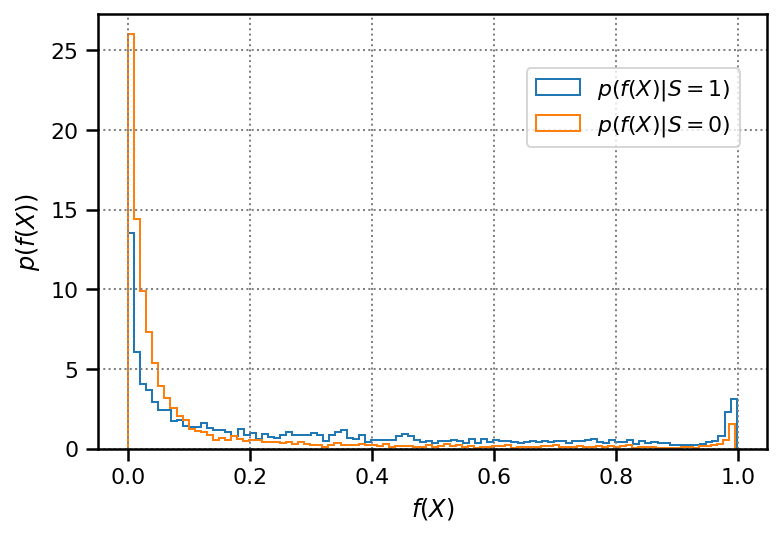

<Figure size 432x432 with 0 Axes>

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'

y_pred_S1=gb.predict_proba(X_train)[:,1][sensitive==1]
y_pred_S0=gb.predict_proba(X_train)[:,1][sensitive==0]

fig, ax1 = plt.subplots()
ax1.set_facecolor('white')
ax1.grid(color='gray', linestyle=':', linewidth=1)
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams["font.size"] = 16.0
ax1.hist(y_pred_S1, bins=100, density=1, histtype="step", label="$p(f(X)|S=1)$")
ax1.hist(y_pred_S0, bins=100, density=1, histtype="step", label="$p(f(X)|S=0)$")
leg = plt.legend(loc="best")
#plt.ylim(0,15)
plt.xlabel("$f(X)$")
plt.ylabel("$p(f(X))$")
plt.legend(loc="upper left")
plt.savefig("f-plain.pdf")
plt.legend(loc='upper center', bbox_to_anchor=(0.8, 0.9),shadow=False, ncol=1)
plt.show()
plt.title('Unfair model (FAGTB with   =0.000)')
plt.savefig("test.pdf" , bbox_inches='tight')
plt.clf() 

plt.show()


Train the FAGTB algorithm on 10 iterations:

In [ ]:
table = [0,0,0,0]

for i in range(10):
    X_train, X_test, y_train, y_test, sensitive, sensitivet = DATA_TRAIN_TEST(1,'sex',"income-per-year",['sex','income-per-year','race-sex']) 
   
    classifier= FAGTB(n_estimators=300, learning_rate = 0.01, max_depth = 10,min_samples_split=1.0, min_impurity =False, max_features =20, regression =1)
    y_pred = classifier.fit(X_train.values, y_train.values, sensitive, LAMBDA=0.15, Xtest=X_test.values, yt=y_test,
                      sensitivet=sensitivet)
    
    ##### Results on Test dataset #####
    y_predt2 = classifier.predict(X_test.values)
    print('')
    print('Results on test set :')
    Res = display_results(y_predt2, y_test.values, sensitivet)
    table = np.vstack([table,[Res['Accuracy']*100,Res['PRULE'],Res['DispFPR'],Res['DispFNR']]])
np.savetxt(sys.stdout, np.mean(table[1:,], axis=0).astype(float), '%5.2f')


Results for FAGTB with logistic regression on Adversarial

> The results correspond in the following order: Accuracy, PRULE, DispFPR, DispFNR)


In [34]:
np.set_printoptions(suppress=True) 
np.mean(table[1:,], axis=0).astype(float)

array([84.26305948, 90.35539438,  0.03408385,  0.27099708])

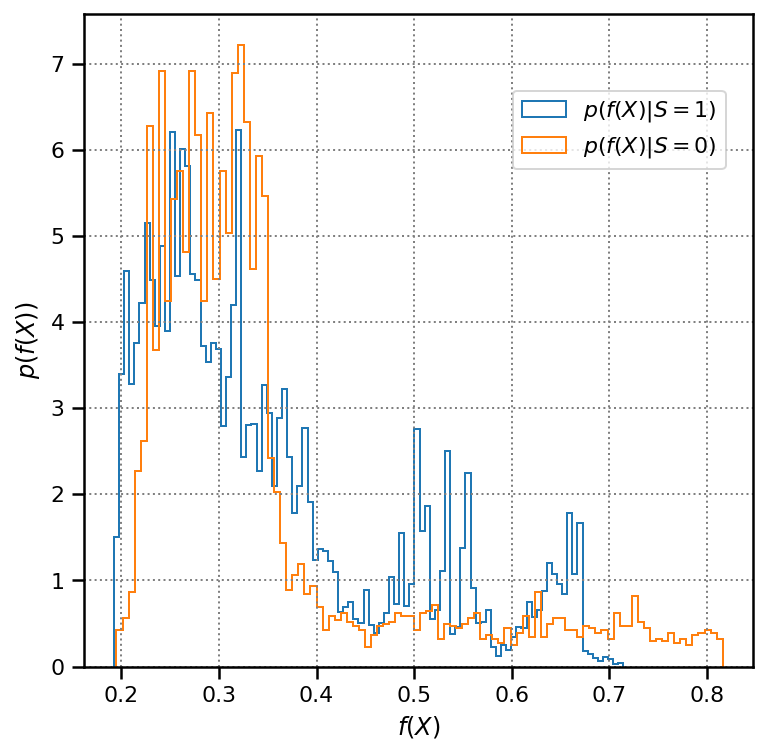

<Figure size 432x432 with 0 Axes>

In [37]:

y_pred_S1=classifier.predict(X_train.values)[sensitive==1]
y_pred_S0=classifier.predict(X_train.values)[sensitive==0]

fig, ax1 = plt.subplots()
ax1.set_facecolor('white')
ax1.grid(color='gray', linestyle=':', linewidth=1)
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams["font.size"] = 16.0
ax1.hist(y_pred_S1, bins=100, density=1, histtype="step", label="$p(f(X)|S=1)$")
ax1.hist(y_pred_S0, bins=100, density=1, histtype="step", label="$p(f(X)|S=0)$")
leg = plt.legend(loc="best")
#plt.ylim(0,15)
plt.xlabel("$f(X)$")
plt.ylabel("$p(f(X))$")
plt.legend(loc="upper left")
plt.savefig("f-plain.pdf")
plt.legend(loc='upper center', bbox_to_anchor=(0.8, 0.9),shadow=False, ncol=1)
plt.show()
plt.title('Unfair model (FAGTB with   =0.015)')
plt.savefig("test.pdf" , bbox_inches='tight')
plt.clf() 

plt.show()
